# GEONE - logging

Some functions in geone allow for logging, based on the `logging` package. This allows to write information, warnings and errors in a log file.

First create a `logger`, an instance of the class `logging.Logger` (see `logging` package for details). Then this `logger` can be passed as keyword argument to some functions of `geone` package.

A simple example is given below.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# import package 'geone'
import geone as gn

import logging

## Set-up for logging

In [2]:
# Log file
log_file = 'a_logging_example.log'

# Set logging format (for log entries)
logging_format = '%(asctime)s.%(msecs)03d | %(levelname)-8s | %(name)-15s >>> %(message)s'
date_format = '%Y-%m-%d %H:%M:%S'

# Reset logging module (if required)
logger_root = logging.getLogger()
for h in logger_root.handlers: logger_root.removeHandler(h)
for f in logger_root.filters:  logger_root.removeFilter (f)

# Set logging level
# log_level = logging.DEBUG     # more logged messages
log_level = logging.INFO      # .
# log_level = logging.WARNING   # .
# log_level = logging.ERROR     # .
# log_level = logging.CRITICAL  # less logged messages

# Optional : open the log file and write an header
with open(log_file, 'w') as f:
    f.write("A LOGGING EXAMPLE\n")

# Create logging file
logging.basicConfig(
        filename=log_file,
        encoding='utf-8',
        level=logging.INFO,
        filemode='a',
        format=logging_format,
        datefmt=date_format)

## Example - DeeSse

See notebook `ex_deesse_01_basics.ipynb`.

In [3]:
# Get logger and set a name
logger = logging.getLogger('Example-Deesse')

# Load data
# ---------
logger.info('Loading data') # write "info" message in the log file

# Data directory
data_dir = 'data' # directory containing the training image file

# Training image 
filename = os.path.join(data_dir, 'ti.txt')
ti = gn.img.readImageTxt(filename)

# Simulation grid
nx, ny, nz = 100, 100, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

# Hard data (point set)
filename = os.path.join(data_dir, 'hd.txt')
hd = gn.img.readPointSetTxt(filename)

# Input for DeeSse
# -----------------
logger.info('Input for deesse') # write "info" message in the log file

nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,        # dimension of the simulation grid (number of cells)
    sx=sx, sy=sy, sz=sz,        # cells units in the simulation grid
    ox=ox, oy=oy, oz=oz,        # origin of the simulation grid
    nv=1, varname='code',       # number of variable(s), name of the variable(s)
    TI=ti,                      # TI (class gn.deesseinterface.Img)
    dataPointSet=hd,            # hard data (optional)
    distanceType='categorical', # distance type: proportion of mismatching nodes (categorical var., default)
    #conditioningWeightFactor=10.,  # put more weight to conditioning data (if needed)
    nneighboringNode=24,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.05,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
    seed=444,                   # seed (initialization of the random number generator)
    nrealization=nreal)         # number of realization(s)

# Input for DeeSse
# -----------------
logger.info('Running deesse') # write "info" message in the log file

t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input, nthreads=8, logger=logger) # pass the logger as keyword argument
t2 = time.time() # end time

logger.info(f'Elapsed time: {t2-t1:.2g} sec') # write "info" message in the log file

In [4]:
# Total number of warning(s), and warning messages
deesse_output['nwarning'], deesse_output['warnings']

(0, [])

Compute statistics and plot the results.

In [5]:
# Categories and colors
categ_val = [0, 1, 2]
categ_col = ['lightblue', 'blue', 'orange'] # colors for the proportion maps

# Colors of the hard data
hd_col = gn.imgplot.get_colors_from_values(hd.val[3], categ=True, categVal=categ_val, categCol=categ_col)

# Retrieve the realizations
sim = deesse_output['sim']

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = gn.img.imageListCategProp(sim, categ_val)


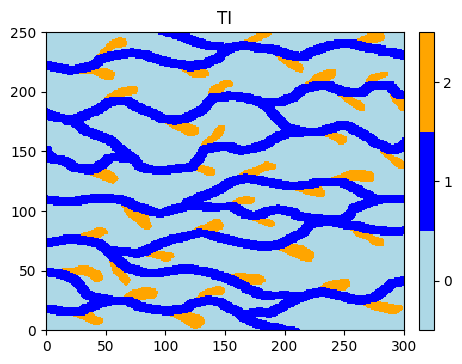

In [6]:
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, categ=True, categVal=categ_val, categCol=categ_col)
plt.title('TI')
plt.show()


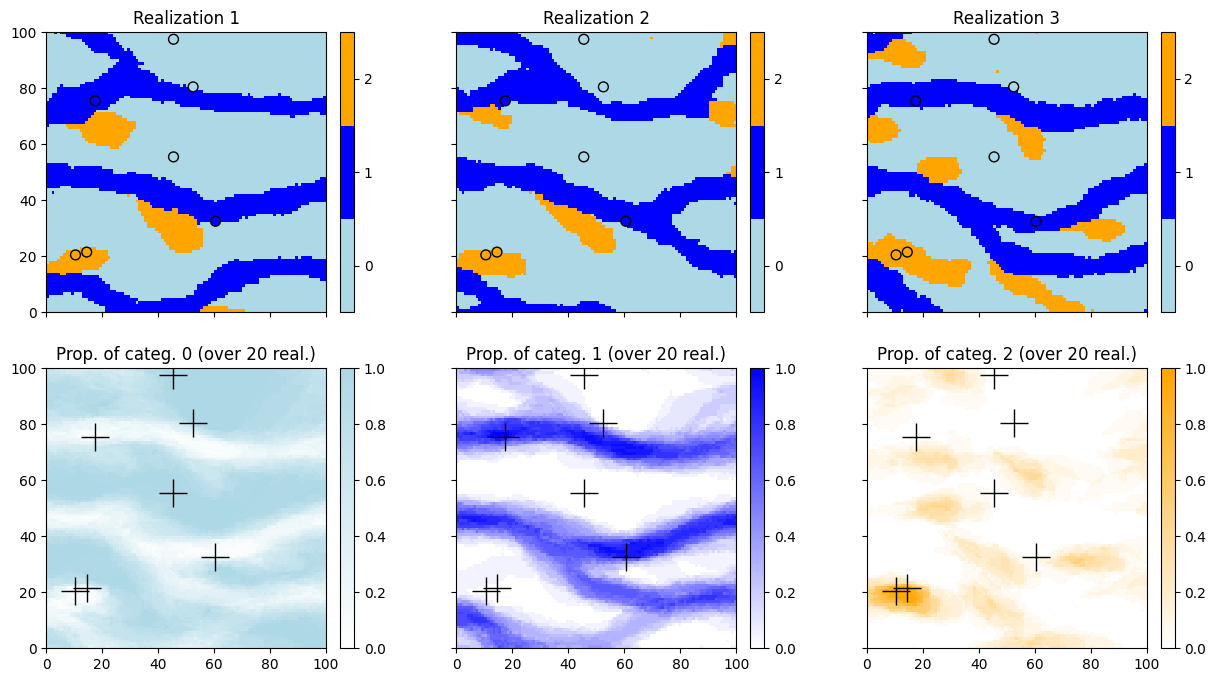

In [7]:
# Color maps for the proportion maps
prop_col = categ_col # colors for the proportion maps
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]



# Display
plt.subplots(2, 3, figsize=(15,8), sharex=True, sharey=True)
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], categ=True, categVal=categ_val, categCol=categ_col)
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='black', linewidths=1) # hard data
    plt.title(f'Realization {i+1}')

for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, cmap=cmap[i])
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='black') # add hard data points
    plt.title(f'Prop. of categ. {i} (over {nreal} real.)')
    
plt.show()

## Example - Kriging and Sequential Gaussian Simulation (SGS)

See dedicated notebooks (e.g. `ex_geosclassic_1d_1.ipynb`).

In [8]:
# Get logger and set a name
logger = logging.getLogger('Example-Kriging-SGS')

# Set-up: 1D grid, data
# ---------------------
logger.info('Set-up: 1D grid, data') # write "info" message in the log file

# Simulation grid (domain)
nx = 1000 # number of cells
sx = 1.0  # cell unit
ox = 0.0  # origin

# Data points
# - equality data
x = np.array([57.2, 83.6, 438.9, 861.8, 973.3])
v = np.array([ 3.4,  6.4,   4.2,   2.9,   3.3])
v_err_std = 0.2

# - inequality data
x_ineq     = np.array([ 257.2,  690.3])
v_ineq_min = np.array([np.nan,    4.8])
v_ineq_max = np.array([   5.4, np.nan])

# Set covariance model
# --------------------
logger.info('Set covariance model') # write "info" message in the log file
cov_model = gn.covModel.CovModel1D(elem=[
    ('matern', {'w':7., 'r':150, 'nu':2.0}) # elementary contribution
    ], name='cov model')

logger.info(cov_model) # write "info" message in the log file

# Kriging
# -------
logger.info('Kriging') # write "info" message in the log file
t1 = time.time() # start time
krig = gn.multiGaussian.multiGaussianRun(
                        cov_model, nx, sx, ox,
                        mode='estimation', algo='classic', output_mode='array', 
                        x=x, v=v, v_err_std=v_err_std,
                        x_ineq=x_ineq, v_ineq_min=v_ineq_min, v_ineq_max=v_ineq_max,
                        method='ordinary_kriging',
                        searchRadius=700.0, nneighborMax=20,
                        nthreads=8, 
                        logger=logger) # pass the logger as keyword argument
t2 = time.time() # end time
logger.info(f'Elapsed time: {t2-t1:.2g} sec') # write "info" message in the log file

# SGS
# ---
logger.info('SGS') # write "info" message in the log file
t1 = time.time() # start time
sgs = gn.multiGaussian.multiGaussianRun(
                        cov_model, nx, sx, ox,
                        mode='simulation', algo='classic', output_mode='array', 
                        x=x, v=v, v_err_std=v_err_std,
                        x_ineq=x_ineq, v_ineq_min=v_ineq_min, v_ineq_max=v_ineq_max,
                        method='ordinary_kriging', 
                        searchRadius=700.0, nneighborMax=20,
                        nreal=200,
                        nproc=4, nthreads_per_proc=4, 
                        logger=logger) # pass the logger as keyword argument
t2 = time.time() # end time
logger.info(f'Elapsed time: {t2-t1:.2g} sec') # write "info" message in the log file


Compute statistics and plot the results.

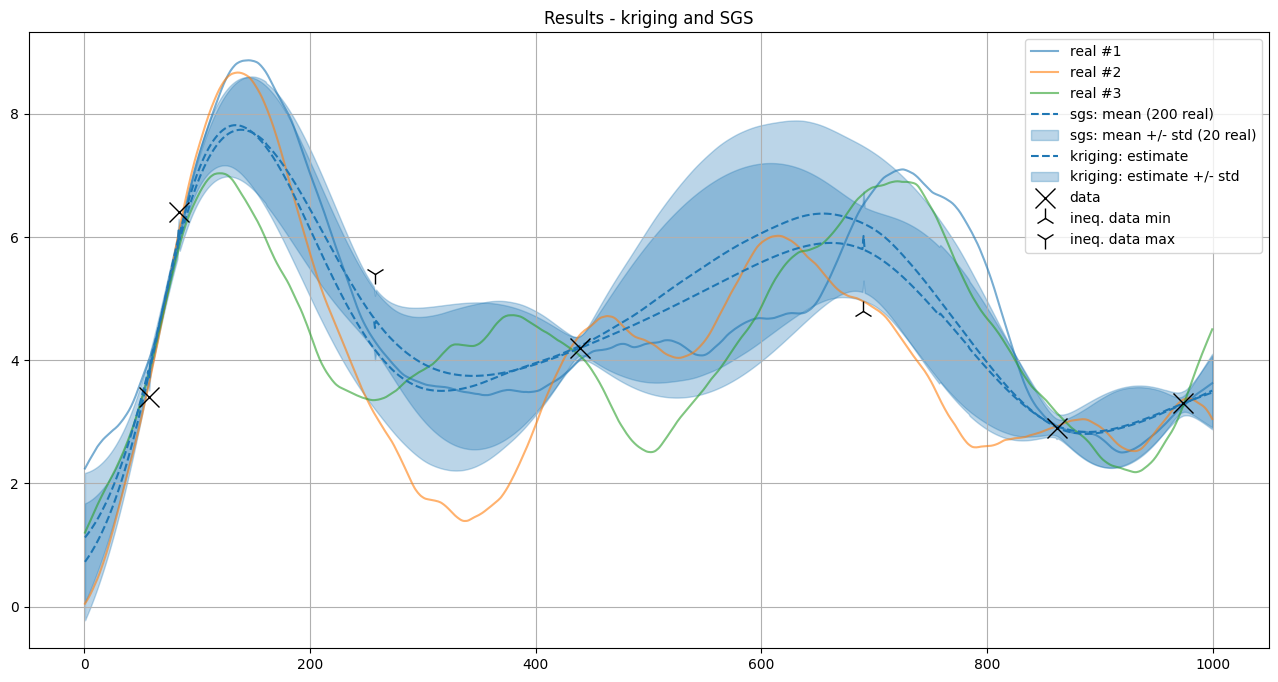

In [9]:
# Mean and standard deviation of the sgs
sgs_mean = sgs.mean(axis=0)
sgs_std = sgs.std(axis=0)

# Coordinate of cell centers
xc = ox + (0.5 + np.arange(nx))*sx

# Display
plt.figure(figsize=(16,8))

# First simulations
for i in range(3):
    plt.plot(xc, sgs[i], alpha=0.6, label=f'real #{i+1}')

# Simulation mean and mean +/- std
col_sim = 'tab:blue'
plt.plot(xc, sgs_mean, c=col_sim, ls='dashed', label=f'sgs: mean ({sgs.shape[0]} real)')
plt.fill_between(xc, sgs_mean - sgs_std, sgs_mean + sgs_std,
                 color=col_sim, alpha=.3, label=f'sgs: mean +/- std ({nreal} real)')

# Kriging
col_krig = 'tab:green'
plt.plot(xc, krig[0], c=col_sim, ls='dashed', label=f'kriging: estimate')
plt.fill_between(xc, krig[0] - krig[1], krig[0] + krig[1],
                 color=col_sim, alpha=.3, label=f'kriging: estimate +/- std')

# Data
plt.plot(x, v, 'x', c='k', markersize=15, label='data') # add equality data points
plt.plot(x_ineq, v_ineq_min, '2', c='k', markersize=15, label='ineq. data min') # add inequality data, lower bound
plt.plot(x_ineq, v_ineq_max, '1', c='k', markersize=15, label='ineq. data max') # add inequality data, lower bound

plt.grid()
plt.legend()
plt.title(f'Results - kriging and SGS')

plt.show()

## Ending

In [10]:
# Get logger and set a name
logger = logging.getLogger('Example-End')

logger.info('All done!') # write "info" message in the log file
